In [1]:
import os
import time
import shutil
import pickle

import torch
import torch.nn.functional as F

from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from tensorboard_logger import configure, log_value

from model import RecurrentAttention
from utils import AverageMeter

from torchvision import transforms, utils, models
from PIL import Image

import torch

import utils
import data_loader

from trainer import Trainer
from config import get_config

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import pandas as pd

import json

In [2]:
def load_inputs(impath):
    to_tens = transforms.ToTensor()
    return to_tens(Image.open(impath).convert('RGB')).unsqueeze(0)

In [3]:
# class miniConv(torch.nn.Module):
#     def __init__(self, resnet):
#         super().__init__()
        
#         self.conv1 = resnet.conv1
#         self.bn1 = resnet.bn1
#         self.relu = resnet.relu
#         self.maxpool = resnet.maxpool
#         self.layer1 = resnet.layer1
#         self.adp_pool = torch.nn.AdaptiveAvgPool2d((1,1))
        
#     def forward(self, x):
        
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.maxpool(x)
#         x = self.layer1(x)
#         x = self.adp_pool(x)
#         x = x.flatten(start_dim = 1)
#         return x
        

In [4]:
# model = miniConv(resnet = torchvision.models.resnet18())
# test = torch.rand(1,3, 256, 256)
# model(test).shape

In [5]:
# import torchvision

# torchvision.models.resnet18()

In [6]:
# type(mig_data)

In [7]:
m = open("../../pooling/data/migration_data.json",)
mig_data = json.load(m)
m.close()
mig_data = pd.DataFrame.from_dict(mig_data, orient = 'index').reset_index()
mig_data.columns = ['muni_id', 'num_migrants']
q = 2
mig_data['class'] = pd.qcut(mig_data['num_migrants'], q = q, labels = [i for i in range(q)])
mig_data

,muni_id,num_migrants,class
0,484001001,42055.0,1
1,484001002,4017.0,1
2,484001003,11992.0,1
3,484001004,762.0,1
4,484001005,7551.0,1
...,...,...,...
2326,484032049,2487.0,1
2327,484032050,2024.0,1
2328,484032051,3084.0,1
2329,484032052,2919.0,1


In [8]:
mig_data['class'].value_counts()

0    1166
1    1165
Name: class, dtype: int64

In [9]:
def get_png_names(directory):
    images = []
    for i in os.listdir(directory):
        try:
            if os.path.isdir(os.path.join(directory, i)):
                new_path = os.path.join(directory, i, "pngs")
                image = os.listdir(new_path)[0]
                images.append(os.path.join(directory, i, "pngs", image))
        except:
            pass
    return images


            

image_names = get_png_names("../../pooling/data/MEX/")

ys = []
for i in image_names:
        dta = mig_data[mig_data["muni_id"] == i.split("/")[5]]
        if len(dta) != 0:
            ys.append(dta['class'].values[0])

In [10]:
import random

# train_num = int(25 * .70)

# train_indices = random.sample(range(0, 25), train_num)
# val_indices = [i for i in range(0, 25) if i not in train_indices]



import random

train_num = int(len(image_names) * .70)

train_indices = random.sample(range(0, len(image_names)), train_num)
val_indices = [i for i in range(0, len(image_names)) if i not in train_indices]

In [11]:
# val_indices

In [12]:
import torchvision

batch_size = 1

# train = [(load_inputs(image_paths[i]).squeeze()[:, 0:28, 0:28], ys[i]) for i in range(0, 93)]
# val = [(load_inputs(image_paths[i]).squeeze()[:, 0:28, 0:28], ys[i]) for i in range(93, 133)]

# brighten = torchvision.transforms.functional.adjust_brightness(brightness_factor = 2)


train = [(torchvision.transforms.functional.adjust_brightness(load_inputs(image_names[i]), brightness_factor = 2).squeeze(), ys[i]) for i in train_indices]
val = [(torchvision.transforms.functional.adjust_brightness(load_inputs(image_names[i]), brightness_factor = 2).squeeze(), ys[i]) for i in val_indices]


train_dl = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
val_dl = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)

In [13]:
print("Num training: ", len(train_dl))
print("Num validation: ", len(val_dl))

Num training:  1204
Num validation:  517


In [14]:
import numpy as np
from utils import plot_images

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [15]:
config, unparsed = get_config()

In [16]:
trainer = Trainer(config, (train_dl, val_dl))

In [17]:
# test = torch.rand(1,3,50,50)
# test = test.view(test.shape[0], -1)
# test.shape

In [ ]:
trainer.train()

0.2s - loss: 1.522 - acc: 100.000:   2%|▏         | 2/93 [00:00<00:05, 17.39it/s]


[*] Train on 93 samples, validate on 40 samples

Epoch: 1/200 - LR: 0.000300


57.2s - loss: 1.073 - acc: 100.000: : 1204it [00:57, 21.05it/s]                   


train loss: 1.041 - train acc: 51.163 - val loss: 0.971 - val acc: 49.516 - val err: 50.484 [*]


0.2s - loss: 0.925 - acc: 0.000:   3%|▎         | 3/93 [00:00<00:05, 16.38it/s]


Epoch: 2/200 - LR: 0.000300


54.7s - loss: 1.111 - acc: 100.000: : 1204it [00:54, 22.00it/s]                   


train loss: 0.991 - train acc: 51.744 - val loss: 1.002 - val acc: 52.031 - val err: 47.969 [*]


0.1s - loss: 0.962 - acc: 0.000:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch: 3/200 - LR: 0.000300


55.9s - loss: 0.964 - acc: 0.000: : 1204it [00:55, 21.55it/s]                     


train loss: 0.973 - train acc: 57.060 - val loss: 0.952 - val acc: 65.957 - val err: 34.043 [*]


0.2s - loss: 0.880 - acc: 100.000:   2%|▏         | 2/93 [00:00<00:08, 10.68it/s]


Epoch: 4/200 - LR: 0.000300


55.6s - loss: 0.808 - acc: 100.000: : 1204it [00:55, 21.64it/s]                   


train loss: 0.929 - train acc: 62.791 - val loss: 0.909 - val acc: 67.118 - val err: 32.882 [*]


0.1s - loss: 1.114 - acc: 0.000:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch: 5/200 - LR: 0.000300


55.8s - loss: 0.708 - acc: 100.000: : 1204it [00:55, 21.58it/s]                   
0.0s - loss: 0.733 - acc: 100.000:   0%|          | 0/93 [00:00<?, ?it/s]

train loss: 0.915 - train acc: 63.953 - val loss: 0.911 - val acc: 66.151 - val err: 33.849

Epoch: 6/200 - LR: 0.000300


54.6s - loss: 0.970 - acc: 100.000: : 1204it [00:54, 22.05it/s]                   


train loss: 0.914 - train acc: 62.542 - val loss: 0.915 - val acc: 67.311 - val err: 32.689 [*]


0.2s - loss: 0.751 - acc: 100.000:   2%|▏         | 2/93 [00:00<00:05, 17.08it/s]


Epoch: 7/200 - LR: 0.000300


54.7s - loss: 0.797 - acc: 100.000: : 1204it [00:54, 22.02it/s]                   
0.0s - loss: 0.723 - acc: 100.000:   0%|          | 0/93 [00:00<?, ?it/s]

train loss: 0.884 - train acc: 65.033 - val loss: 0.892 - val acc: 67.311 - val err: 32.689

Epoch: 8/200 - LR: 0.000300


55.1s - loss: 0.563 - acc: 100.000: : 1204it [00:55, 21.87it/s]                   


train loss: 0.875 - train acc: 66.113 - val loss: 0.835 - val acc: 68.279 - val err: 31.721 [*]


0.2s - loss: 0.421 - acc: 100.000:   2%|▏         | 2/93 [00:00<00:05, 15.25it/s]


Epoch: 9/200 - LR: 0.000300


54.8s - loss: 1.995 - acc: 0.000: : 1204it [00:54, 21.96it/s]                     
0.0s - loss: 0.848 - acc: 100.000:   0%|          | 0/93 [00:00<?, ?it/s]

train loss: 0.880 - train acc: 64.120 - val loss: 0.872 - val acc: 65.571 - val err: 34.429

Epoch: 10/200 - LR: 0.000300


56.0s - loss: 0.347 - acc: 100.000: : 1204it [00:56, 21.50it/s]                   


train loss: 0.873 - train acc: 65.033 - val loss: 0.835 - val acc: 70.600 - val err: 29.400 [*]


0.0s - loss: 0.616 - acc: 100.000:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch: 11/200 - LR: 0.000300


55.3s - loss: 5.139 - acc: 0.000: : 1204it [00:55, 21.76it/s]                     
0.0s - loss: 0.569 - acc: 100.000:   0%|          | 0/93 [00:00<?, ?it/s]

train loss: 0.878 - train acc: 64.950 - val loss: 0.910 - val acc: 68.665 - val err: 31.335

Epoch: 12/200 - LR: 0.000300


54.3s - loss: 1.124 - acc: 0.000: : 1204it [00:54, 22.19it/s]                     
0.1s - loss: 0.577 - acc: 100.000:   0%|          | 0/93 [00:00<?, ?it/s]

train loss: 0.862 - train acc: 66.528 - val loss: 0.855 - val acc: 69.052 - val err: 30.948

Epoch: 13/200 - LR: 0.000300


54.6s - loss: 0.815 - acc: 100.000: : 1204it [00:54, 22.06it/s]                   
0.0s - loss: 0.805 - acc: 100.000:   0%|          | 0/93 [00:00<?, ?it/s]

train loss: 0.879 - train acc: 64.452 - val loss: 0.954 - val acc: 47.969 - val err: 52.031

Epoch: 14/200 - LR: 0.000300


54.2s - loss: 1.032 - acc: 100.000: : 1204it [00:54, 22.23it/s]                   
0.1s - loss: 1.008 - acc: 100.000:   0%|          | 0/93 [00:00<?, ?it/s]

train loss: 0.948 - train acc: 48.007 - val loss: 0.948 - val acc: 52.031 - val err: 47.969

Epoch: 15/200 - LR: 0.000300


54.7s - loss: 0.968 - acc: 100.000: : 1204it [00:54, 22.03it/s]                   
0.0s - loss: 0.950 - acc: 100.000:   0%|          | 0/93 [00:00<?, ?it/s]

train loss: 0.943 - train acc: 51.661 - val loss: 0.937 - val acc: 52.031 - val err: 47.969

Epoch: 16/200 - LR: 0.000300


54.9s - loss: 0.992 - acc: 100.000: : 1204it [00:54, 21.93it/s]                   
0.1s - loss: 1.009 - acc: 100.000:   0%|          | 0/93 [00:00<?, ?it/s]

train loss: 0.939 - train acc: 54.817 - val loss: 0.899 - val acc: 60.155 - val err: 39.845

Epoch: 17/200 - LR: 0.000300


55.4s - loss: 0.581 - acc: 100.000: : 1204it [00:55, 21.72it/s]                   
0.1s - loss: 0.264 - acc: 100.000:   1%|          | 1/93 [00:00<00:08, 10.49it/s]

train loss: 0.906 - train acc: 61.296 - val loss: 0.852 - val acc: 66.925 - val err: 33.075

Epoch: 18/200 - LR: 0.000300


55.2s - loss: 0.773 - acc: 100.000: : 1204it [00:55, 21.83it/s]                   
0.1s - loss: 0.874 - acc: 100.000:   0%|          | 0/93 [00:00<?, ?it/s]

train loss: 0.878 - train acc: 64.701 - val loss: 0.896 - val acc: 63.250 - val err: 36.750

Epoch: 19/200 - LR: 0.000300


55.4s - loss: 0.206 - acc: 100.000: : 1204it [00:55, 21.72it/s]                   
0.1s - loss: 1.173 - acc: 0.000:   0%|          | 0/93 [00:00<?, ?it/s]

train loss: 0.886 - train acc: 63.206 - val loss: 0.872 - val acc: 65.377 - val err: 34.623

Epoch: 20/200 - LR: 0.000300


55.9s - loss: 2.787 - acc: 0.000: : 1204it [00:55, 21.54it/s]                     
0.1s - loss: 0.848 - acc: 100.000:   0%|          | 0/93 [00:00<?, ?it/s]

train loss: 0.865 - train acc: 65.532 - val loss: 0.854 - val acc: 67.698 - val err: 32.302

Epoch: 21/200 - LR: 0.000300


24.4s - loss: 1.378 - acc: 0.000: : 521it [00:24, 22.22it/s]                      

In [ ]:
un = []

for i,o in val_dl:
    if o not in un:
        un.append(o)
        
un

In [31]:
trues, preds = [], []

for i,o in train_dl:
    trues.append(o.item())
    preds.append(trainer.predict(1, i, o))

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [33]:
confusion_matrix(trues, preds)

array([[263, 363],
       [158, 420]])

In [34]:
accuracy_score(trues, preds)

0.5672757475083057

In [1]:
import pickle
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from utils import denormalize, bounding_box

def denormalize(T, coords):
    return 0.5 * ((coords + 1.0) * T)

In [6]:
def plot(plot_dir, epoch):
    # read in pickle files
    glimpses = pickle.load(open(plot_dir + "g_{}.p".format(epoch), "rb"))
    locations = pickle.load(open(plot_dir + "l_{}.p".format(epoch), "rb"))
    
    from ipdb import set_trace

    glimpses = np.concatenate(glimpses)
    glimpses = np.expand_dims(glimpses, axis = 0)
    
    print(glimpses.shape)
    
    # grab useful params
    size = int(plot_dir.split("_")[2].split("x")[0])
    
#     size = int(min(H, W) / (6 * 2))
    
    size = int(min(glimpses.shape[2], glimpses.shape[3]) / (6 * 2))
    
    num_anims = len(locations)
    num_cols = glimpses.shape[0]
    img_shape = glimpses.shape[2]
    
    # denormalize coordinates
    coords = [denormalize(img_shape, l) for l in locations]
    
#     print(coords)
    
    if num_cols == 1:
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        
        plt.imshow(np.transpose(glimpses[0], (1,2,0)), cmap="Greys_r")
#         plt.get_xaxis().set_visible(False)
#         plt.get_yaxis().set_visible(False)   
        
        def updateData(i):
            color = "r"
            co = coords[i]
            for p in ax.patches:
                p.remove()
            c = co[0]
            rect = bounding_box(c[0], c[1], size, color)
            ax.add_patch(rect)
        
        # animate
        anim = animation.FuncAnimation(
            fig, updateData, frames = num_anims, interval=500, repeat=True
        )

        # save as mp4
        name = plot_dir + "epoch_{}.mp4".format(epoch)
        anim.save(name, extra_args=["-vcodec", "h264", "-pix_fmt", "yuv420p"])        
        
    else:
    
        print(np.array(coords))

        fig, axs = plt.subplots(nrows=1, ncols=num_cols)
        # fig.set_dpi(100)

        # plot base image
        for j, ax in enumerate(axs.flat):
            print(glimpses[j].shape)
            ax.imshow(np.transpose(glimpses[j], (1,2,0)), cmap="Greys_r")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        def updateData(i):
            color = "r"
            co = coords[i]
            for j, ax in enumerate(axs.flat):
                for p in ax.patches:
                    p.remove()
                c = co[j]
                rect = bounding_box(c[0], c[1], size, color)
                ax.add_patch(rect)

        # animate
        anim = animation.FuncAnimation(
            fig, updateData, frames = num_anims, interval = 500, repeat = True
        )

        # save as mp4
        name = plot_dir + "epoch_{}.mp4".format(epoch)
        anim.save(name, extra_args=["-vcodec", "h264", "-pix_fmt", "yuv420p"])


(1, 3, 1092, 1368)


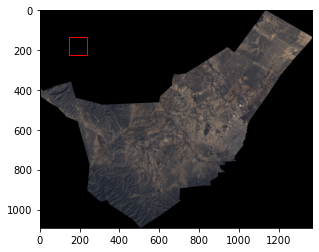

In [7]:
plot("./plots/ram_6_50x50_1/", 10)